tgb - 8/27/2019 - The goal of this notebook is to use Noah's toolbox to make sense of the mid-latitude blow-up from the unstable NN. The plan is to use a combination of notebooks:  
https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/stephans-devlog/6.2-Debug-cut-off-runs.ipynb  
https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/021_Jacobians_for_Noah.ipynb  
https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/016_Stampede2_Jacobians.ipynb  
in order to:  
1) Find the space-time coordinates of the blowup  
2) Define base state associated to it  
3) Perturb that base state 1000 times  
4) Calculate its "smooth" linear response function  
5) Save the linear function and base state for use in Noah's ntoebook

# 1) Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import *
from cbrain.normalization import *
from cbrain.models import fc_model
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pickle
import scipy.integrate as sin
from tensorflow.python.ops.parallel_for.gradients import batch_jacobian
%matplotlib inline

Define neural networks

In [2]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [3]:
scale_dict = load_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl')

In [4]:
CAMDIR = '/scratch/05488/tg847872/revision_debug/'
input_transform = InputNormalizer(
    xr.open_dataset(f'{CAMDIR}/001_norm.nc'),
    in_vars,
    'mean', 'maxrs')

In [5]:
output_transform = DictNormalizer(xr.open_dataset(CAMDIR+'001_norm.nc'), 
                                  out_vars, scale_dict)

Define stable and unstable NNs models

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
def fc_model(input_shape, output_shape, hidden_layers, conservation_layer=False,
             inp_sub=None, inp_div=None, norm_q=None):
    inp = Input(shape=(input_shape,))

    # First hidden layer
    x = Dense(hidden_layers[0])(inp)
    x = LeakyReLU()(x)

    # Remaining hidden layers
    for h in hidden_layers[1:]:
        x = Dense(h)(x)
        x = LeakyReLU()(x)

    if conservation_layer:
        x = SurRadLayer(inp_sub, inp_div, norm_q)([inp, x])
        x = MassConsLayer(inp_sub, inp_div, norm_q)([inp, x])
        out = EntConsLayer(inp_sub, inp_div, norm_q)([inp, x])

    else:
        out = Dense(output_shape)(x)

    return tf.keras.models.Model(inp, out)

Load stable and unstable NNs weights

In [7]:
STABLENN_path = '/home1/05823/tg851228/006_8col_pnas_exact/'
UNSTABNN_path = '/home1/05823/tg851228/007_32col_pnas_exact/'

stabNN = fc_model(94, 65, [256]*9)
stabNN.load_weights(
    f'{STABLENN_path}weights.h5'
)

unstabNN = fc_model(94, 65, [256]*9)
unstabNN.load_weights(
    f'{UNSTABNN_path}weights.h5'
)

# 2) Find the blowup point and the corresponding base state

Open the CAM dataset

In [8]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')

Find longitude/latitude of blowup point and extract base state of each blowup  
Based on https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/stephans-devlog/6.2-Debug-cut-off-runs.ipynb

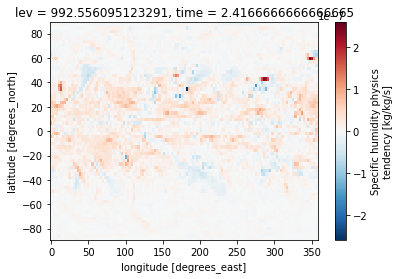

In [9]:
cam_ds.PHQ.isel(time=-45, lev=-1).plot()

In [10]:
t_array = [-50,-45,-40,-35,-30,-25,-20,-15,-10,-5]
Nt = len(t_array)
in_array = np.zeros((Nt,94))
for it,t in enumerate(t_array):
    ilat = np.argmax(cam_ds.PHQ.isel(time=t, lev=-1).max('lon').values)
    ilon = np.argmax(cam_ds.PHQ.isel(time=t, lev=-1).max('lat').values)
    print('it=',it,'/',Nt-1,' t=',t,' ilat,ilon,lat,lon=',\
          ilat, ilon, \
          cam_ds.lat[ilat].values, cam_ds.lon[ilon].values)
    in_array[it,:] = np.concatenate([
        cam_ds.NNQBP.isel(time=t, lat=ilat, lon=ilon).values,
        cam_ds.NNTBP.isel(time=t, lat=ilat, lon=ilon).values,
        cam_ds.NNVBP.isel(time=t, lat=ilat, lon=ilon).values,
        cam_ds.NNPS.isel(time=t, lat=ilat, lon=ilon).values[None],
        cam_ds.NNSOLIN.isel(time=t, lat=ilat, lon=ilon).values[None],
        cam_ds.NNSHF.isel(time=t, lat=ilat, lon=ilon).values[None],
        cam_ds.NNLHF.isel(time=t, lat=ilat, lon=ilon).values[None],
    ])[None, :]

it= 0 / 9  t= -50  ilat,ilon,lat,lon= 53 124 59.9970201084913 348.75
it= 1 / 9  t= -45  ilat,ilon,lat,lon= 47 102 43.25419466535094 286.875
it= 2 / 9  t= -40  ilat,ilon,lat,lon= 47 102 43.25419466535094 286.875
it= 3 / 9  t= -35  ilat,ilon,lat,lon= 47 103 43.25419466535094 289.6875
it= 4 / 9  t= -30  ilat,ilon,lat,lon= 47 103 43.25419466535094 289.6875
it= 5 / 9  t= -25  ilat,ilon,lat,lon= 47 103 43.25419466535094 289.6875
it= 6 / 9  t= -20  ilat,ilon,lat,lon= 47 104 43.25419466535094 292.5
it= 7 / 9  t= -15  ilat,ilon,lat,lon= 47 104 43.25419466535094 292.5
it= 8 / 9  t= -10  ilat,ilon,lat,lon= 47 104 43.25419466535094 292.5
it= 9 / 9  t= -5  ilat,ilon,lat,lon= 47 105 43.25419466535094 295.3125


# 3) Perturb each basestate with normal perturbations to obtain smooth linear response function

Follows https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/021_Jacobians_for_Noah.ipynb

## 3.1) Get base state in right format

Load Noah's dataset

In [11]:
path = '/home1/05823/tg851228/NC_DATA/2019-05-01-tropical_mean.nc'
noah_ds = xr.open_mfdataset(path, decode_times=False, concat_dim='time')

Interpolate to get thermodynamic profiles

In [12]:
# Height [m]
Z_INTERP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.z.values))
# Interface height [m]
ZI_INTERP = np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.z.values))
# Density [kg/m3]
RHO_INTERP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.flip(noah_ds.rho.values)[0,:])
# Specific humidity [kg/kg]
NNQBP = 1e-3*np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                       np.fliplr(noah_ds.QV.values)[0,:])
# Temperature [K]
NNTBP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                  np.fliplr(noah_ds.TABS.values)[0,:])
# Meridional velocity [m/s]
NNVBP = np.interp(cam_ds.lev.values,np.fliplr(noah_ds.p.values)[0,:],
                  np.fliplr(noah_ds.V.values)[0,:])
# Surface pressure [Pa]
NNPS = 1e2*noah_ds.p.values[:,0]
# Solar insolation [W/m2]
NNSOLIN = noah_ds.SOLIN.values
# Sensible heat flux [W/m2]
NNSHF = noah_ds.SHF.values
# Latent heat flux [W/m2]
NNLHF = noah_ds.LHF.values

Ideal gas law/hydrostasy/moist thermo to get geopotential height more rigorously

In [13]:
# Ideal gas law -> rho=p(R_d*T_v)
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg

r = NNQBP/(NNQBP**0-NNQBP)
Tv = NNTBP*(r**0+r/eps)/(r**0+r)
RHO = 1e2*cam_ds.lev.values/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*cam_ds.lev.values,y=1/(G*RHO))
Z = np.concatenate((np.zeros(1,),Z))
Z = Z-Z[-1]+Z_INTERP[-1]

In [14]:
qvI = 1e-3*np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
                     np.fliplr(noah_ds.QV.values)[0,:])
TI = np.interp(cam_ds.ilev.values,np.fliplr(noah_ds.p.values)[0,:],
               np.fliplr(noah_ds.TABS.values)[0,:])

rI = qvI/(qvI**0-qvI)
TvI = TI*(rI**0+rI/eps)/(rI**0+rI)
RHOI = 1e2*cam_ds.ilev.values/(R_D*TvI)

ZI = -sin.cumtrapz(x=1e2*cam_ds.ilev.values,y=1/(G*RHOI))
ZI = np.concatenate((np.zeros(1,),ZI))
ZI = ZI-ZI[-1]+ZI_INTERP[-1]

Create base state vector used for Noah's code

In [15]:
it = 3 # Time index for base state near blowup

In [16]:
base_state = {}
base_state['qv'] = in_array[it,:30]
base_state['T'] = in_array[it,30:60]
base_state['v'] = in_array[it,60:90]
base_state['ps'] = in_array[it,90]
base_state['S0'] = in_array[it,91]
base_state['SHF'] = in_array[it,92]
base_state['LHF'] = in_array[it,93]
base_state['p'] = cam_ds.lev.values
base_state['p_interface'] = cam_ds.ilev.values
base_state['z'] = Z
base_state['z_interface'] = ZI
base_state['rho'] = RHO
base_state['rho_interface'] = RHOI

## 3.2) Perturb base state

In [17]:
# Variables that we will perturb 
profiles = {'qv','T','v'}
scalars = {'ps','S0','SHF','LHF'}

Perturb profiles and scalars

In [18]:
pert_scale = 0.01 # Normal perturbation of standard deviation 5%

In [19]:
Npert = 10000 # Number of perturbations

In [20]:
# We perturb each variable using a normal distribution of mean 0 and standard deviation 10%
Np = np.size(base_state['p']) # Number of vertical levels
pert_state = {};

for i,profile in enumerate(profiles):
    print('i=',i,' profile=',profile,'          ',end='\r')
    pert_state[profile] = np.zeros((Np,Npert))
    
    for j,lev in enumerate(base_state['p']):
        #print('j=',j,' level=',lev)
        pert_state[profile][j,:] = base_state[profile][j]+\
        np.random.normal(loc=0,scale=pert_scale,size=(Npert,))*\
        np.tile(base_state[profile][j],(Npert,))

In [21]:
for i,scalar in enumerate(scalars):
    print('i=',i,' scalar=',scalar,'          ',end='\r')
    pert_state[scalar] = base_state[scalar]+\
        np.random.normal(loc=0,scale=pert_scale,size=(Npert,))*np.tile(base_state[scalar],(Npert,))

Check that perturbation follows normal distribution

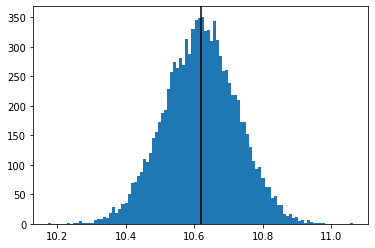

In [22]:
plt.hist(1e3*pert_state['qv'][28],bins=100)
plt.axvline(x=1e3*base_state['qv'][28],color='k')

## 3.3) Calculate "smoothed" linear response function  
Follows https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/021_Jacobians_for_Noah.ipynb

In [23]:
def get_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)[None]})
    return J.squeeze()
def get_batch_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = batch_jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)})
    return J.squeeze()

In [24]:
in_vec_pert = np.concatenate([pert_state['qv'],
                              pert_state['T'],
                              pert_state['v'],
                              np.tile(pert_state['ps'],(1,1)),
                              np.tile(pert_state['S0'],(1,1)),
                              np.tile(pert_state['SHF'],(1,1)),
                              np.tile(pert_state['LHF'],(1,1)),
                             ])[None, :].astype('float32')
in_vec_pert = np.transpose(in_vec_pert[0,:,:]) # Shape = [#batches,input size]

In [25]:
cf_inp = np.zeros((1,94))
for index in range (94):
    if index<30: cf_inp[0,index]=L_V;
    elif index<60: cf_inp[0,index]=C_P;
    else: cf_inp[0,index]=1;
        
cf_oup = np.zeros((1,65))
for index in range (65):
    if index<30: cf_oup[0,index]=L_V;
    elif index<60: cf_oup[0,index]=C_P;
    else: cf_oup[0,index]=1;

In [26]:
Jstab = get_batch_jacobian(input_transform.transform(in_vec_pert),stabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [27]:
Junstab = get_batch_jacobian(input_transform.transform(in_vec_pert),unstabNN)*\
np.transpose(cf_oup/output_transform.scale)/\
(cf_inp*input_transform.div)

In [28]:
LRFstab = Jstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
LRFunstab = Junstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
LRFstab_mean = np.mean(LRFstab,axis=0)
LRFunstab_mean = np.mean(LRFunstab,axis=0)

Case # 1 Stable
Case # 2 Unstable


<Figure size 480x320 with 0 Axes>

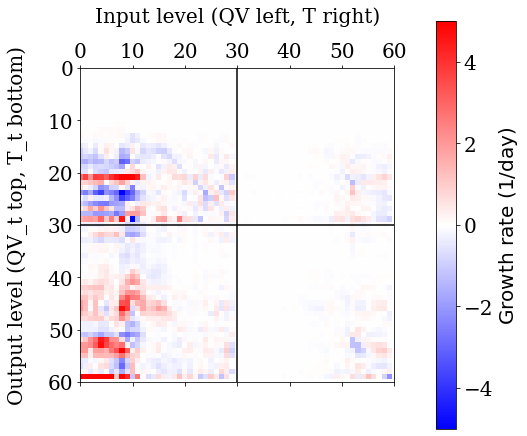

<Figure size 480x320 with 0 Axes>

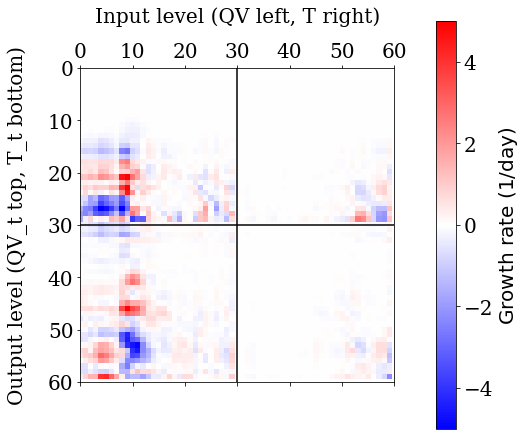

In [29]:
plt.rc('font', family='serif')

for ifig in range(2):
    plt.figure(num=None,dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(figsize=(7.5,7.5))
    
    if ifig==0: toplot = 24*3600*LRFstab_mean; case = 'Stable'
    elif ifig==1: toplot = 24*3600*LRFunstab_mean; case = 'Unstable'
    print('Case #',ifig+1,case)
    cax = ax.matshow(toplot,cmap='bwr', vmin=-5, vmax=5)

    x = np.linspace(0.,60.,100);

    plt.plot(x,Np*x**0, color='k')
    plt.plot(Np*x**0,x, color='k')
    plt.xlim((0,2*Np)); plt.ylim((2*Np,0))

    cbar = fig.colorbar(cax, pad = 0.1)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/day\right)}$',\
                   rotation=90, fontsize = 20)

    plt.xticks(fontsize=20); plt.yticks(fontsize=20)
    ax.xaxis.set_label_position('top')
    X = plt.xlabel(r'Input level (QV left, T right)', fontsize = 20)
    ax.xaxis.labelpad = 20
    Y = plt.ylabel(r'Output level (QV_t top, T_t bottom)', fontsize = 20)
    ax.yaxis.labelpad = 20

## 3.4) Eigenvalue analysis

In [30]:
Name = ['MeanLRF_stable','MeanLRF_unstable']
jac = {}
for ijac,name in enumerate(Name):
    if ijac==0: tmp = LRFstab_mean
    elif ijac==1: tmp = LRFunstab_mean
    
    jac[name] = {}
    jac[name]['q'] = {}
    jac[name]['T'] = {}
    jac[name]['q']['q'] = tmp[:30,:30]
    jac[name]['q']['T'] = tmp[:30,30:]
    jac[name]['T']['q'] = tmp[30:,:30]
    jac[name]['T']['T'] = tmp[30:,30:]

Text(0, 0.5, 'Eigenvalue [1/day]')

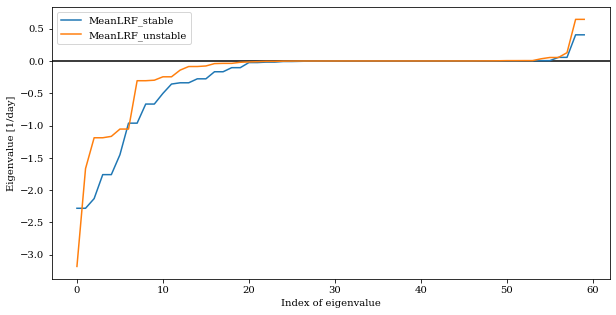

In [31]:
TQ_sp = {}

plt.figure(figsize=(10,5))
plt.axhline(y=0,color='k')

for ijac,name in enumerate(Name):
    if ijac==0: tmp = LRFstab_mean; ls = '-'
    elif ijac==1: tmp = LRFunstab_mean; ls = '-'
    elif ijac==2: tmp = LRFmean_stab; ls = '--'
    elif ijac==3: tmp = LRFmean_unstab; ls = '--'

    Eval, Evec = LA.eig(tmp)
    lam = 24*3600*np.real(Eval)
    TQ_sp[name] = [np.min(lam),np.max(lam)]
    plt.plot(np.sort(lam),label=name,linestyle=ls)

plt.legend()
plt.xlabel('Index of eigenvalue')
plt.ylabel('Eigenvalue [1/day]')

# 4) Save LRFs and base states for all timesteps for Noah's coupling algorithm

Parameters

In [32]:
pert_scale = 0.01 # Normal perturbation of standard deviation 5%
Npert = 5000 # Number of perturbations

Initialization

In [33]:
base_state = {}
pert_state = {}
jac = {}
pert_state_mean = {}

Loop over timesteps

In [34]:
for it,t in enumerate(t_array):
    print('it=',it,' and t=',t,'               ')
    # Base state
    base_state[it] = {}
    base_state[it]['qv'] = in_array[it,:30]
    base_state[it]['T'] = in_array[it,30:60]
    base_state[it]['v'] = in_array[it,60:90]
    base_state[it]['ps'] = in_array[it,90]
    base_state[it]['S0'] = in_array[it,91]
    base_state[it]['SHF'] = in_array[it,92]
    base_state[it]['LHF'] = in_array[it,93]
    base_state[it]['p'] = cam_ds.lev.values
    base_state[it]['p_interface'] = cam_ds.ilev.values
    base_state[it]['z'] = Z
    base_state[it]['z_interface'] = ZI
    base_state[it]['rho'] = RHO
    base_state[it]['rho_interface'] = RHOI
    # Perturbed profiles
    pert_state[it] = {};
    for i,profile in enumerate(profiles):
        print('i=',i,' profile=',profile,'          ',end='\r')
        pert_state[it][profile] = np.zeros((Np,Npert))
        for j,lev in enumerate(base_state[it]['p']):
            pert_state[it][profile][j,:] = base_state[it][profile][j]+\
            np.random.normal(loc=0,scale=pert_scale,size=(Npert,))*\
            np.tile(base_state[it][profile][j],(Npert,))
    # Perturbed scalars
    for i,scalar in enumerate(scalars):
        print('i=',i,' scalar=',scalar,'          ',end='\r')
        pert_state[it][scalar] = base_state[it][scalar]+\
        np.random.normal(loc=0,scale=pert_scale,size=(Npert,))*\
        np.tile(base_state[it][scalar],(Npert,))
    # Perturbed input batch to feed to NN
    in_vec_pert = np.concatenate([pert_state[it]['qv'],
                                  pert_state[it]['T'],
                                  pert_state[it]['v'],
                                  np.tile(pert_state[it]['ps'],(1,1)),
                                  np.tile(pert_state[it]['S0'],(1,1)),
                                  np.tile(pert_state[it]['SHF'],(1,1)),
                                  np.tile(pert_state[it]['LHF'],(1,1)),
                                 ])[None, :].astype('float32')
    in_vec_pert = np.transpose(in_vec_pert[0,:,:]) # Shape = [#batches,input size]
    # Stable Jacobian
    print('Calculating Jacobian from stable NN')
    Jstab = get_batch_jacobian(input_transform.transform(in_vec_pert),stabNN)*\
    np.transpose(cf_oup/output_transform.scale)/\
    (cf_inp*input_transform.div)
    # Unstable Jacobian
    print('Calculating Jacobian from unstable NN')
    Junstab = get_batch_jacobian(input_transform.transform(in_vec_pert),unstabNN)*\
    np.transpose(cf_oup/output_transform.scale)/\
    (cf_inp*input_transform.div)
    # Linear response functions
    LRFstab = Jstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
    LRFunstab = Junstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
    LRFstab_mean = np.mean(LRFstab,axis=0)
    LRFunstab_mean = np.mean(LRFunstab,axis=0)
    # Save LRFs
    jac[it] = {}
    for ijac,name in enumerate(Name):
        if ijac==0: tmp = LRFstab_mean
        elif ijac==1: tmp = LRFunstab_mean
        jac[it][name] = {}
        jac[it][name]['q'] = {}
        jac[it][name]['T'] = {}
        jac[it][name]['q']['q'] = tmp[:30,:30]
        jac[it][name]['q']['T'] = tmp[:30,30:]
        jac[it][name]['T']['q'] = tmp[30:,:30]
        jac[it][name]['T']['T'] = tmp[30:,30:]
    # Calculate mean of pert_state which should be close to base_state for reference
    pert_state_mean[it] = {}
    for i,profile in enumerate(profiles):
        print('i=',i,' profile=',profile,'          ',end='\r')
        pert_state_mean[it][profile] = np.mean(pert_state[it][profile],axis=1)
    for i,scalar in enumerate(scalars):
        print('i=',i,' scalar=',scalar,'          ',end='\r')
        pert_state_mean[it][scalar] = np.mean(pert_state[it][scalar])

it= 0  and t= -50                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 1  and t= -45                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 2  and t= -40                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 3  and t= -35                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 4  and t= -30                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 5  and t= -25                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 6  and t= -20                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 7  and t= -15                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 8  and t= -10                
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
it= 9  and t= -5            

In [35]:
path = '/home1/05823/tg851228/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [36]:
hf = open(path+'9_9_LRF.pkl','wb')
ForNoah = {"base_state" : base_state,
           "mean_pert_state" : pert_state_mean,
           "linear_response_functions" : jac}
pickle.dump(ForNoah,hf)
hf.close()

# 5) Repeat for Mike's experiments 

tgb - 9/13/2019 - Find threshold in % for which initial unstable modes go away @t=1

In [18]:
def get_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)[None]})
    return J.squeeze()
def get_batch_jacobian(x, model):
    sess = tf.keras.backend.get_session()
    jac = batch_jacobian(model.output, model.input)
    J = sess.run(jac, feed_dict={model.input: x.astype(np.float32)})
    return J.squeeze()

In [19]:
# Variables that we will perturb 
profiles = {'qv','T','v'}
scalars = {'ps','S0','SHF','LHF'}

In [20]:
cf_inp = np.zeros((1,94))
for index in range (94):
    if index<30: cf_inp[0,index]=L_V;
    elif index<60: cf_inp[0,index]=C_P;
    else: cf_inp[0,index]=1;
        
cf_oup = np.zeros((1,65))
for index in range (65):
    if index<30: cf_oup[0,index]=L_V;
    elif index<60: cf_oup[0,index]=C_P;
    else: cf_oup[0,index]=1;

In [21]:
it = 1
Name = ['MeanLRF_stable','MeanLRF_unstable']
Np = np.size(base_state['p']) # Number of vertical levels
Npert = 5000 # Number of perturbations
#pert_array = [0.01,0.025,0.05,0.1,0.25,0.5] # Perturbation amplitudes
#pert_array = [0.1,0.13,0.16,0.19,0.22,0.25]
pert_array = [0.3,0.35,0.4]
base_state = {}
pert_state = {}
jac = {}
pert_state_mean = {}

In [22]:
base_state = {}
base_state['qv'] = in_array[it,:30]
base_state['T'] = in_array[it,30:60]
base_state['v'] = in_array[it,60:90]
base_state['ps'] = in_array[it,90]
base_state['S0'] = in_array[it,91]
base_state['SHF'] = in_array[it,92]
base_state['LHF'] = in_array[it,93]
base_state['p'] = cam_ds.lev.values
base_state['p_interface'] = cam_ds.ilev.values
base_state['z'] = Z
base_state['z_interface'] = ZI
base_state['rho'] = RHO
base_state['rho_interface'] = RHOI

In [23]:
for ipert,pert in enumerate(pert_array):
    print('ipert=',ipert,' perturbation=',pert,'          ')
    # Perturbed profiles
    pert_state[ipert] = {};
    for i,profile in enumerate(profiles):
        print('i=',i,' profile=',profile,'          ',end='\r')
        pert_state[ipert][profile] = np.zeros((Np,Npert))
        for j,lev in enumerate(base_state['p']):
            pert_state[ipert][profile][j,:] = base_state[profile][j]+\
            np.random.normal(loc=0,scale=pert,size=(Npert,))*\
            np.tile(base_state[profile][j],(Npert,))
    # Perturbed scalars
    for i,scalar in enumerate(scalars):
        print('i=',i,' scalar=',scalar,'          ',end='\r')
        pert_state[ipert][scalar] = base_state[scalar]+\
        np.random.normal(loc=0,scale=pert,size=(Npert,))*\
        np.tile(base_state[scalar],(Npert,))
    # Perturbed input batch to feed to NN
    in_vec_pert = np.concatenate([pert_state[ipert]['qv'],
                                  pert_state[ipert]['T'],
                                  pert_state[ipert]['v'],
                                  np.tile(pert_state[ipert]['ps'],(1,1)),
                                  np.tile(pert_state[ipert]['S0'],(1,1)),
                                  np.tile(pert_state[ipert]['SHF'],(1,1)),
                                  np.tile(pert_state[ipert]['LHF'],(1,1)),
                                 ])[None, :].astype('float32')
    in_vec_pert = np.transpose(in_vec_pert[0,:,:]) # Shape = [#batches,input size]
    # Stable Jacobian
    print('Calculating Jacobian from stable NN')
    Jstab = get_batch_jacobian(input_transform.transform(in_vec_pert),stabNN)*\
    np.transpose(cf_oup/output_transform.scale)/\
    (cf_inp*input_transform.div)
    # Unstable Jacobian
    print('Calculating Jacobian from unstable NN')
    Junstab = get_batch_jacobian(input_transform.transform(in_vec_pert),unstabNN)*\
    np.transpose(cf_oup/output_transform.scale)/\
    (cf_inp*input_transform.div)
    # Linear response functions
    LRFstab = Jstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
    LRFunstab = Junstab[:,:(2*Np),:(2*Np)] # Only keep the d(dq/dt,dT/dt)/d(q,T) Jacobian
    LRFstab_mean = np.mean(LRFstab,axis=0)
    LRFunstab_mean = np.mean(LRFunstab,axis=0)
    # Save LRFs
    jac[ipert] = {}
    for ijac,name in enumerate(Name):
        if ijac==0: tmp = LRFstab_mean
        elif ijac==1: tmp = LRFunstab_mean
        jac[ipert][name] = {}
        jac[ipert][name]['q'] = {}
        jac[ipert][name]['T'] = {}
        jac[ipert][name]['q']['q'] = tmp[:30,:30]
        jac[ipert][name]['q']['T'] = tmp[:30,30:]
        jac[ipert][name]['T']['q'] = tmp[30:,:30]
        jac[ipert][name]['T']['T'] = tmp[30:,30:]
    # Calculate mean of pert_state which should be close to base_state for reference
    pert_state_mean[ipert] = {}
    for i,profile in enumerate(profiles):
        print('i=',i,' profile=',profile,'          ',end='\r')
        pert_state_mean[ipert][profile] = np.mean(pert_state[ipert][profile],axis=1)
    for i,scalar in enumerate(scalars):
        print('i=',i,' scalar=',scalar,'          ',end='\r')
        pert_state_mean[ipert][scalar] = np.mean(pert_state[ipert][scalar])

ipert= 0  perturbation= 0.3           
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
ipert= 1  perturbation= 0.35           
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN
ipert= 2  perturbation= 0.4           
Calculating Jacobian from stable NN
Calculating Jacobian from unstable NN


In [24]:
path = '/home1/05823/tg851228/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [25]:
hf = open(path+'9_20_LRF.pkl','wb')
ForNoah = {"base_state" : base_state,
           "mean_pert_state" : pert_state_mean,
           "linear_response_functions" : jac}
pickle.dump(ForNoah,hf)
hf.close()